In [39]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import color
import cv2
from statistics import mean
from sklearn.preprocessing import StandardScaler

In [40]:
os.getcwd()

'/Users/leoniedevolder/Documents/Thesis/Python/RandomForest'

In [41]:
def load_and_process_images_newmicroscope(base_dir, target_size=(100, 100)):
    images = []
    original_images = []
    labels = []

    # Loop door alle datum-mappen in de base_dir
    for datum_map in os.listdir(base_dir):
        if datum_map.startswith('.'):
            continue  # negeer verborgen mappen
        datum_pad = os.path.join(base_dir, datum_map)
        if not os.path.isdir(datum_pad):
            continue

        # Kijk in zowel basin3 als basin5
        for bassin_folder in ['basin3', 'basin5']:
            bassin_pad = os.path.join(datum_pad, bassin_folder, '10x')
            if os.path.exists(bassin_pad):
                for foto in os.listdir(bassin_pad):
                    fotopad = os.path.join(bassin_pad, foto)
                    im = cv2.imread(fotopad, cv2.IMREAD_UNCHANGED)
                    if im is not None:
                        original_images.append(im)

                        # Convert naar grijs (indien nog in kleur) en resize
                        if len(im.shape) == 3:
                            im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                        else:
                            im_gray = im  # al grijs

                        im_resized = cv2.resize(im_gray, target_size, interpolation=cv2.INTER_LINEAR)

                        images.append(im_resized)
                        labels.append(datum_map)  # label is de datum

    return np.array(images), original_images, labels

target_size = (250, 150)
base_dir = "../microscope_images/newmicroscope"
imagesnew, originalsnew, labelsnew = load_and_process_images_newmicroscope(base_dir, target_size)


In [42]:
def load_and_process_images_oldmicroscope(base_dir, target_size=(100, 100)):
    images = []
    original_images = []
    labels = []

    # Loop door alle datum-mappen in de base_dir
    for datum_map in os.listdir(base_dir):
        if datum_map.startswith('.'):
            continue  # negeer verborgen mappen
        datum_pad = os.path.join(base_dir, datum_map)
        if not os.path.isdir(datum_pad):
            continue

        # Kijk in zowel basin3 als basin5
        for bassin_folder in ['basin3', 'basin5']:
            bassin_pad = os.path.join(datum_pad, bassin_folder)
            if os.path.exists(bassin_pad):
                for foto in os.listdir(bassin_pad):
                    fotopad = os.path.join(bassin_pad, foto)
                    im = cv2.imread(fotopad, cv2.IMREAD_UNCHANGED)
                    if im is not None:
                        original_images.append(im)

                        # Convert naar grijs (indien nog in kleur) en resize
                        if len(im.shape) == 3:
                            im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                        else:
                            im_gray = im  # al grijs

                        im_resized = cv2.resize(im_gray, target_size, interpolation=cv2.INTER_LINEAR)

                        images.append(im_resized)
                        labels.append(datum_map)  # label is de datum

    return np.array(images), original_images, labels

target_size = (250, 150)
base_dir = "../microscope_images/oldmicroscopedata"
imagesold, originalsold, labelsold = load_and_process_images_oldmicroscope(base_dir, target_size)

In [43]:
# Combineer de grijs-geschaalde en geresize-de afbeeldingen (NumPy-arrays)
images = np.concatenate([imagesold, imagesnew], axis=0)

# Combineer de originele kleurafbeeldingen (lijsten)
originals = originalsold + originalsnew

# Combineer de labels (lijsten)
labels = labelsold + labelsnew

In [44]:
print(imagesnew[0].shape)
print(originalsnew[0].shape)
print(len(imagesnew))

print(imagesold[0].shape)
print(originalsold[0].shape)
print(len(imagesold))

(150, 250)
(960, 1280, 3)
3434
(150, 250)
(768, 1024, 3)
1132


In [45]:
from datetime import datetime
import numpy as np

# Combineer eerst zoals je eerder deed
images = np.concatenate([imagesold, imagesnew], axis=0)
labels = labelsold + labelsnew

# Sorteer op datum
sorted_indices = sorted(
    range(len(labels)),
    key=lambda i: datetime.strptime(labels[i], "%Y-%m-%d")
)

# Pas sortering toe
labels = [labels[i] for i in sorted_indices]
images = images[sorted_indices]

In [46]:
print(images[0].shape)
print(originals[0].shape)
print(len(images))


(150, 250)
(768, 1024, 3)
4566


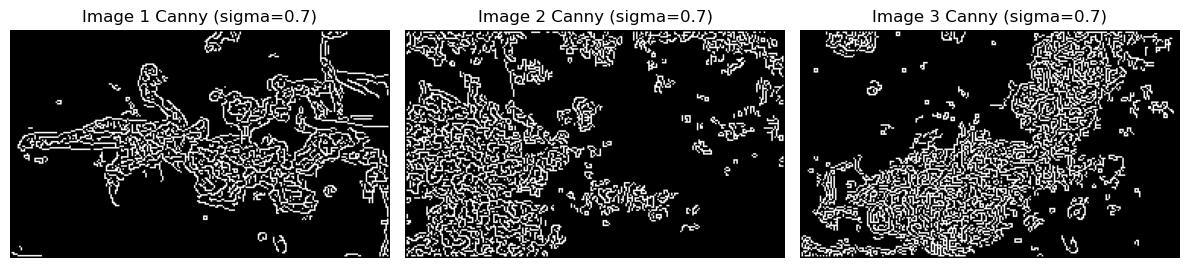

In [47]:
import random
from skimage import feature
import matplotlib.pyplot as plt

# Functie om Canny edge detection toe te passen met sigma = 0.7
def apply_canny_with_sigma(image, sigma=0.7):
    return feature.canny(image, sigma=sigma)  # Skimage Canny edge detection

# Normaliseer en pas Canny toe op alle afbeeldingen in X met sigma = 0.7
X_canny = [apply_canny_with_sigma(img / 255.0, sigma=0.7) for img in images]  # Normaliseer naar [0, 1] en pas Canny toe

# Selecteer willekeurige indices
num_samples = 3 # Aantal willekeurige afbeeldingen
random_indices = random.sample(range(len(X_canny)), num_samples)  # Willekeurige indices selecteren

# Visualiseer de resultaten van de willekeurige afbeeldingen na Canny (sigma = 0.7)
plt.figure(figsize=(num_samples * 4, 4))

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_canny[idx], cmap='gray')
    plt.title(f"Image {i+1} Canny (sigma=0.7)")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Functie om afbeeldingen om te zetten naar 1D-vectors (flatten) voor UMAP
def flatten_images(images):
    return np.array([img.flatten() for img in images])

# **UMAP dimensionality reduction**
def apply_umap(X, n_neighbors=30, min_dist=0.1, random_state=15):
    reducer = umap.UMAP(
        n_components=50,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state  # vaste seed
    )
    return reducer.fit_transform(X)

# Flatten alle afbeeldingen na Canny edge detection
X_canny_flattened = flatten_images(X_canny)

X_umap_components = apply_umap(X_canny_flattened, n_neighbors=30, min_dist=0.1)

/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [48]:
print(X_umap_components.shape)  # Controleer de vorm van de UMAP-componenten

(4566, 50)


In [49]:
kLas = pd.read_csv("kla_values_2tanksincludingCODssensor.csv")

kLas['Date'] = pd.to_datetime(kLas['Date']).dt.date

kla_dict = dict(zip(kLas['Date'], kLas['kLa (1/h)']))

# Koppel de gemiddelde airflow naar de labels van de afbeeldingen
image_labels = []
image_datums = []

for datum in labels:
    datum = pd.to_datetime(datum).date()  # Zorg ervoor dat het een date-object is
    
    # Zoek de gemiddelde airflow voor die datum
    klafordatum = kla_dict.get(datum, None)
    
    if klafordatum is not None:
        image_labels.append(klafordatum)  # Voeg het gemiddelde toe als label voor de afbeelding
        image_datums.append(datum)
    else:
        image_labels.append(None)  # Als er geen airflow voor die datum is, voeg None toe

# Omzetten naar numpy array voor consistentie
image_labels = np.array(image_labels)
image_datums = np.array(image_datums)

# Bekijk de resultaten (labels voor je afbeeldingen)
print(image_labels.shape)
print(image_datums[:5])

(4566,)
[datetime.date(2023, 10, 26) datetime.date(2023, 10, 26)
 datetime.date(2023, 10, 26) datetime.date(2023, 10, 26)
 datetime.date(2023, 10, 26)]


In [50]:
import pandas as pd

# === Parameters ===
start_datum = pd.to_datetime("2023-10-25")
eind_datum = pd.to_datetime("2025-02-20")
volledige_datumreeks = pd.date_range(start=start_datum, end=eind_datum, freq='D')


def verwerk_airflowpad(pad_naar_csv):
    # Inlezen
    df = pd.read_csv(pad_naar_csv, parse_dates=["Time"])
    naam_kolom = df.columns[1]  # Neem airflowkolom (bv. 'airflow_basin4')

    # Extraheer datum
    df['Date'] = pd.to_datetime(df['Time'].dt.date)

    # Filter foutwaarden (bijv. 0)
    df = df[df[naam_kolom] != 0]

    # Bereken daggemiddelden
    daggemiddelden = df.groupby('Date')[naam_kolom].mean()

    # Reindex naar volledige datumreeks met NaNs voor ontbrekende dagen
    daggemiddelden = daggemiddelden.reindex(volledige_datumreeks)

    # Interpoleer ontbrekende waarden op basis van tijd
    daggemiddelden_interpol = daggemiddelden.interpolate(method='time')

    # Omzetten naar dataframe
    resultaat = daggemiddelden_interpol.reset_index().rename(columns={'index': 'Date', naam_kolom: 'Airflow'})
    
    return resultaat


# === Verwerk beide bassins ===
daggemiddelden4_interpol = verwerk_airflowpad("../sensor_data/airflowrate_basin4.csv")
daggemiddelden5_interpol = verwerk_airflowpad("../sensor_data/airflowrate_basin5.csv")

# Optioneel: hernoem kolommen voor duidelijkheid
daggemiddelden4_interpol = daggemiddelden4_interpol.rename(columns={'Airflow': 'airflow_basin4'})
daggemiddelden5_interpol = daggemiddelden5_interpol.rename(columns={'Airflow': 'airflow_basin5'})

# Controleer resultaat
print(daggemiddelden4_interpol.head())
print(daggemiddelden5_interpol.head())

        Date  airflow_basin4
0 2023-10-25      489.896456
1 2023-10-26      492.239917
2 2023-10-27      379.306250
3 2023-10-28      207.541029
4 2023-10-29      203.284028
        Date  airflow_basin5
0 2023-10-25      198.088108
1 2023-10-26      225.045480
2 2023-10-27      161.617024
3 2023-10-28      117.524061
4 2023-10-29      105.613125


In [58]:
kLas = pd.read_csv("kla_values_2tanksincludingCODssensor.csv")
otherdata = pd.read_csv("merged_df_2tanksincludingCODssensor.csv")

kLas['Date'] = pd.to_datetime(kLas['Date']).dt.date
otherdata['Date'] = pd.to_datetime(otherdata['Date']).dt.date
daggemiddelden4_interpol['Date'] = pd.to_datetime(daggemiddelden4_interpol['Date']).dt.date
daggemiddelden5_interpol['Date'] = pd.to_datetime(daggemiddelden5_interpol['Date']).dt.date

kla_dict = dict(zip(kLas['Date'], kLas['kLa (1/h)']))
COD_dict = dict(zip(otherdata['Date'], otherdata['CODtprimeff']))
DO4_dict = dict(zip(otherdata['Date'], otherdata['DO_basin4']))
DO5_dict = dict(zip(otherdata['Date'], otherdata['DO_basin5']))
NH4_dict = dict(zip(otherdata['Date'], otherdata['NH4primeff']))
airflow4_dict = dict(zip(daggemiddelden4_interpol['Date'], daggemiddelden4_interpol['airflow_basin4']))
airflow5_dict = dict(zip(daggemiddelden5_interpol['Date'], daggemiddelden5_interpol['airflow_basin5']))

# Koppel de gemiddelde airflow naar de labels van de afbeeldingen
image_labels = []
image_datums = []

for datum in labels:
    datum = pd.to_datetime(datum).date()  # Zorg ervoor dat het een date-object is
    
    # Zoek de gemiddelde airflow voor die datum
    klafordatum = kla_dict.get(datum, None)
    
    if klafordatum is not None:
        image_labels.append(klafordatum)  # Voeg het gemiddelde toe als label voor de afbeelding
        image_datums.append(datum)
    else:
        image_labels.append(None)  # Als er geen airflow voor die datum is, voeg None toe

# Omzetten naar numpy array voor consistentie
image_labels = np.array(image_labels)
image_datums = np.array(image_datums)

# Bekijk de resultaten (labels voor je afbeeldingen)
print(image_labels.shape)
print(image_datums[:5])

# Lijsten waarin de features per afbeelding per dag komen
cod_features = []
nh4_features = []
do4_features = []
do5_features = []
airflow4_features = []
airflow5_features = []

# Voor elke datum in je originele lijst labels (image dates)
for datum in labels:
    datum = pd.to_datetime(datum).date()
    
    # Per variabele de waarde ophalen
    cod_features.append(COD_dict.get(datum, np.nan))
    nh4_features.append(NH4_dict.get(datum, np.nan))
    do4_features.append(DO4_dict.get(datum, np.nan))
    do5_features.append(DO5_dict.get(datum, np.nan))
    airflow4_features.append(airflow4_dict.get(datum, np.nan))
    airflow5_features.append(airflow5_dict.get(datum, np.nan))

# Zet alles in één pandas DataFrame voor overzicht
image_features_df = pd.DataFrame({
    'Date': pd.to_datetime(labels).date,
    'CODt': cod_features,
    'NH4': nh4_features,
    'DO_basin4': do4_features,
    'DO_basin5': do5_features,
    'Airflow_basin4': airflow4_features,
    'Airflow_basin5': airflow5_features
})

# Optioneel: filter out rows with missing values if needed
image_features_df = image_features_df.dropna()

(4566,)
[datetime.date(2023, 10, 26) datetime.date(2023, 10, 26)
 datetime.date(2023, 10, 26) datetime.date(2023, 10, 26)
 datetime.date(2023, 10, 26)]


In [59]:
import pandas as pd
import numpy as np

# Zet alles samen in een DataFrame (als je dat nog niet had)
feature_df = pd.DataFrame({
    "Date": pd.to_datetime(labels),
    "CODt": cod_features,
    "NH4": nh4_features,
    "DO_basin4": do4_features,
    "DO_basin5": do5_features,
    "Airflow_basin4": airflow4_features,
    "Airflow_basin5": airflow5_features
})

# Toon rijen waar minstens 1 waarde ontbreekt
missing_rows = feature_df[feature_df.isna().any(axis=1)]

# Print de datums en bijhorende ontbrekende kolommen
print(missing_rows)

Empty DataFrame
Columns: [Date, CODt, NH4, DO_basin4, DO_basin5, Airflow_basin4, Airflow_basin5]
Index: []


DIT IS DE CODE VOOR DE ORIGINELE DF ZONDER EXTRA DATA

In [60]:
# Stel het aantal UMAP-componenten in
n_components = 50

# Maak een lijst van kolomnamen
column_names = [f"umap{i+1}" for i in range(n_components)]

# Zet de UMAP-resultaten in een DataFrame met automatische kolomnamen
X_umap_df = pd.DataFrame(X_umap_components, columns=column_names)
X_umap_df["Date"] = image_datums

# Labels toevoegen
labels_df = pd.DataFrame({
    "Date": image_datums,
    "kLa": image_labels
})

# Controle
print(X_umap_df.shape)
print(labels_df.shape)
print(X_umap_df["Date"].dtype)
print(labels_df["Date"].dtype)

same_order = (X_umap_df["Date"].values == labels_df["Date"].values).all()
print("Zelfde volgorde:", same_order)

# Combineer alles in één DataFrame
df = pd.concat([X_umap_df, labels_df["kLa"]], axis=1)
print(df.shape)

(4566, 51)
(4566, 2)
object
object
Zelfde volgorde: True
(4566, 52)


In [61]:
# Zorg dat 'Date' een datetime-object is
df["Date"] = pd.to_datetime(df["Date"])

# Definieer train/test maskers
train_mask = (df["Date"] >= "2023-10-26") & (df["Date"] <= "2024-10-09")
test_mask  = (df["Date"] >= "2024-10-16") & (df["Date"] <= "2025-02-19")

# Bereken aantallen
n_train_days = df[train_mask]["Date"].nunique()
n_test_days = df[test_mask]["Date"].nunique()
n_train_images = train_mask.sum()
n_test_images = test_mask.sum()

print(f"Aantal trainingsdagen: {n_train_days}")
print(f"Aantal testdagen: {n_test_days}")
print(f"Aantal trainingsbeelden: {n_train_images}")
print(f"Aantal testbeelden: {n_test_images}")

Aantal trainingsdagen: 64
Aantal testdagen: 23
Aantal trainingsbeelden: 3395
Aantal testbeelden: 1171


In [62]:
df["Date"] = pd.to_datetime(df["Date"])

# Stap 2: Selecteer features en target
feature_cols = [col for col in df.columns if col.startswith("umap")]
X = df[feature_cols]
y = df["kLa"]
dates = df["Date"]

# Stap 3: Maak maskers voor train en test
train_mask = (df["Date"] >= "2023-10-26") & (df["Date"] <= "2024-10-09")
test_mask  = (df["Date"] >= "2024-10-16") & (df["Date"] <= "2025-02-19")

# Stap 4: Train/test splitsen
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
dates_train = dates[train_mask]
dates_test = dates[test_mask]

print(len(X))

4566


EN HIER CODE VOOR UITGEBREIDE DF

In [60]:
# Stap 1: Zorg dat de Date-kolom goed staat
df["Date"] = pd.to_datetime(df["Date"])

# Stap 2: Selecteer alle feature columns (UMAP + extra features)
# Neem alle kolommen behalve 'kLa' en 'Date' als features
feature_cols = [col for col in df.columns if col not in ["kLa", "Date"]]
X = df[feature_cols]
y = df["kLa"]
dates = df["Date"]

# Stap 3: Maak de train/test maskers
train_mask = (df["Date"] >= "2023-10-26") & (df["Date"] <= "2024-10-09")
test_mask  = (df["Date"] >= "2024-10-16") & (df["Date"] <= "2025-02-19")

# Stap 4: Split de data
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
dates_train = dates[train_mask]
dates_test = dates[test_mask]

# Optioneel: controle
print(f"Aantal features: {X.shape[1]}")
print("Features:", X.columns.tolist())
print(X_train.shape, X_test.shape)

Aantal features: 16
Features: ['umap1', 'umap2', 'umap3', 'umap4', 'umap5', 'umap6', 'umap7', 'umap8', 'umap9', 'umap10', 'CODt', 'NH4', 'DO_basin4', 'DO_basin5', 'Airflow_basin4', 'Airflow_basin5']
(3395, 16) (1171, 16)


In [56]:
import numpy as np

def mean_squared_error(y_true, y_pred, squared=True):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    return mse if squared else np.sqrt(mse)

HIER WEER VOOR ORIGINELE

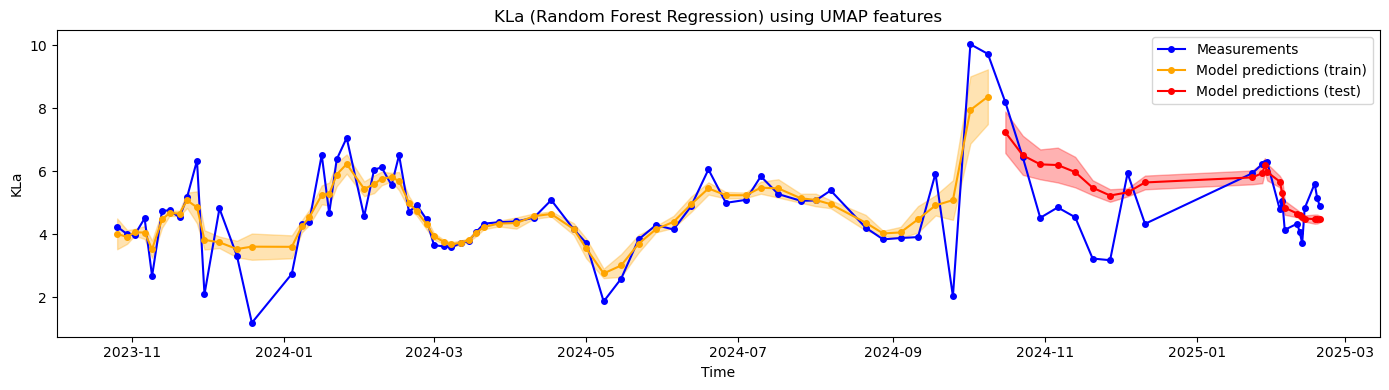

Train RMSE: 0.783 | R²: 0.715 MSE: 0.612
Test RMSE:  1.086 | R²: 0.151 MSE: 1.180


In [63]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
import matplotlib.pyplot as plt

# Stap 5: Train model
model = RandomForestRegressor(n_estimators=50, 
                              min_samples_split = 100, 
                              min_samples_leaf = 50, 
                              max_features = "log2", 
                              max_depth = 10, 
                              random_state=42)
model.fit(X_train, y_train)

# Stap 3: voorspellingen
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

import matplotlib.pyplot as plt

# Zorg dat je in zowel train_results als test_results een 'y_std' kolom hebt:
# Bijvoorbeeld door deze toe te voegen bij het aggregeren:
train_results = pd.DataFrame({
    "Date": dates_train.values,
    "y_true": y_train.values,
    "y_pred": y_pred_train
})

test_results = pd.DataFrame({
    "Date": dates_test.values,
    "y_true": y_test.values,
    "y_pred": y_pred_test
})

train_daily = train_results.groupby("Date").agg(
    y_true=("y_true", "mean"),
    y_pred=("y_pred", "mean"),
    y_std=("y_pred", "std")
).reset_index()

test_daily = test_results.groupby("Date").agg(
    y_true=("y_true", "mean"),
    y_pred=("y_pred", "mean"),
    y_std=("y_pred", "std")
).reset_index()

import matplotlib.pyplot as plt

# Vul eventueel NaN-standaarddeviaties op met nul
train_daily["y_std"] = train_daily["y_std"].fillna(0)
test_daily["y_std"] = test_daily["y_std"].fillna(0)

# Combineer echte waarden (train + test) tot één blauwe lijn
true_all = pd.concat([train_daily[["Date", "y_true"]],
                      test_daily[["Date", "y_true"]]], ignore_index=True).sort_values("Date")

# Begin plot
plt.figure(figsize=(14, 4))

# 📘 Blauwe lijn: echte waarden met stippen
plt.plot(true_all["Date"], true_all["y_true"], '-o', color='blue', label="Measurements", markersize=4)

# 🟠 Oranje lijn: training voorspellingen met puntjes
plt.plot(train_daily["Date"], train_daily["y_pred"], '-o', color='orange', label="Model predictions (train)", markersize=4)
plt.fill_between(train_daily["Date"],
                 train_daily["y_pred"] - train_daily["y_std"],
                 train_daily["y_pred"] + train_daily["y_std"],
                 color='orange', alpha=0.3)

# 🔴 Rode lijn: test voorspellingen met puntjes
plt.plot(test_daily["Date"], test_daily["y_pred"], '-o', color='red', label="Model predictions (test)", markersize=4)
plt.fill_between(test_daily["Date"],
                 test_daily["y_pred"] - test_daily["y_std"],
                 test_daily["y_pred"] + test_daily["y_std"],
                 color='red', alpha=0.3)

# Labels en stijl
plt.xlabel("Time")
plt.ylabel("KLa")
plt.title("KLa (Random Forest Regression) using UMAP features")
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Opslaan en tonen
plt.savefig("kla_predictionsRF.pdf", dpi=300, bbox_inches="tight")
plt.show()

from sklearn.metrics import mean_squared_error, r2_score

# MSE en RMSE
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.3f} | R²: {r2_train:.3f} MSE: {mse_train:.3f}")
print(f"Test RMSE:  {rmse_test:.3f} | R²: {r2_test:.3f} MSE: {mse_test:.3f}")

HIER VOOR UITGEBREIDE

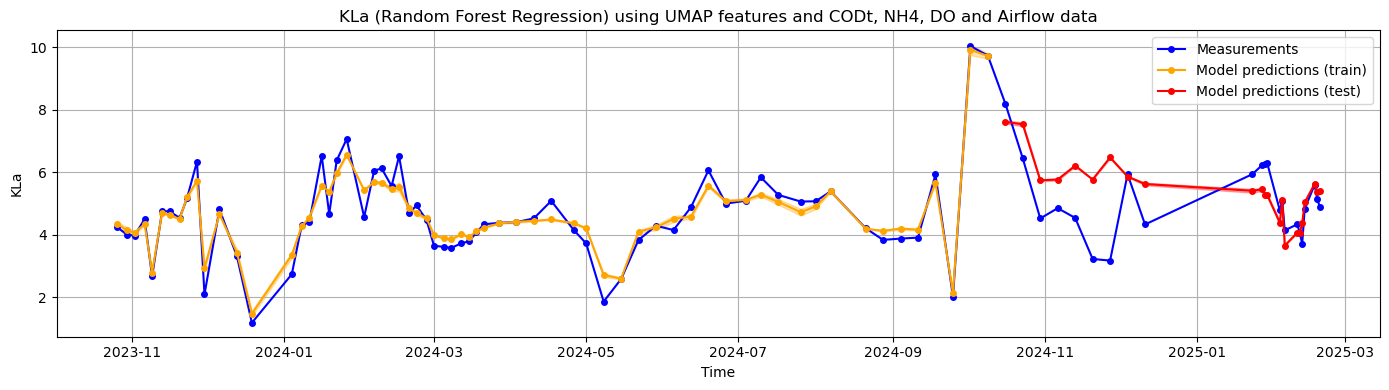

In [66]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
import matplotlib.pyplot as plt

# Stap 5: Train model
model = RandomForestRegressor(n_estimators=100, 
                              min_samples_split = 10, 
                              min_samples_leaf = 5, 
                              max_features = "sqrt", 
                              max_depth = 5, 
                              random_state=42)
model.fit(X_train, y_train)

# Stap 3: voorspellingen
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

import matplotlib.pyplot as plt

# Zorg dat je in zowel train_results als test_results een 'y_std' kolom hebt:
# Bijvoorbeeld door deze toe te voegen bij het aggregeren:
train_results = pd.DataFrame({
    "Date": dates_train.values,
    "y_true": y_train.values,
    "y_pred": y_pred_train
})

test_results = pd.DataFrame({
    "Date": dates_test.values,
    "y_true": y_test.values,
    "y_pred": y_pred_test
})

train_daily = train_results.groupby("Date").agg(
    y_true=("y_true", "mean"),
    y_pred=("y_pred", "mean"),
    y_std=("y_pred", "std")
).reset_index()

test_daily = test_results.groupby("Date").agg(
    y_true=("y_true", "mean"),
    y_pred=("y_pred", "mean"),
    y_std=("y_pred", "std")
).reset_index()

import matplotlib.pyplot as plt

# Vul eventueel NaN-standaarddeviaties op met nul
train_daily["y_std"] = train_daily["y_std"].fillna(0)
test_daily["y_std"] = test_daily["y_std"].fillna(0)

# Combineer echte waarden (train + test) tot één blauwe lijn
true_all = pd.concat([train_daily[["Date", "y_true"]],
                      test_daily[["Date", "y_true"]]], ignore_index=True).sort_values("Date")

# Begin plot
plt.figure(figsize=(14, 4))

# 📘 Blauwe lijn: echte waarden met stippen
plt.plot(true_all["Date"], true_all["y_true"], '-o', color='blue', label="Measurements", markersize=4)

# 🟠 Oranje lijn: training voorspellingen met puntjes
plt.plot(train_daily["Date"], train_daily["y_pred"], '-o', color='orange', label="Model predictions (train)", markersize=4)
plt.fill_between(train_daily["Date"],
                 train_daily["y_pred"] - train_daily["y_std"],
                 train_daily["y_pred"] + train_daily["y_std"],
                 color='orange', alpha=0.3)

# 🔴 Rode lijn: test voorspellingen met puntjes
plt.plot(test_daily["Date"], test_daily["y_pred"], '-o', color='red', label="Model predictions (test)", markersize=4)
plt.fill_between(test_daily["Date"],
                 test_daily["y_pred"] - test_daily["y_std"],
                 test_daily["y_pred"] + test_daily["y_std"],
                 color='red', alpha=0.3)

# Labels en stijl
plt.xlabel("Time")
plt.ylabel("KLa")
plt.title("KLa (Random Forest Regression) using UMAP features and CODt, NH4, DO and Airflow data")
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()

# Opslaan en tonen
plt.savefig("kla_predictionsRFextradata.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import numpy as np

# 1. Zelfgemaakte RMSE-functie
def rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# 2. Maak scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# 3. Definieer zoekruimte (compact maar effectief)
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [10, 50, 100],
    "min_samples_leaf": [10, 20, 50],
    "max_features": ["sqrt", "log2", None]
}

# 4. Randomized search instellen
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=30,                  # probeer 30 random combinaties
    scoring=rmse_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 5. Fit uitvoeren
random_search.fit(X_train, y_train)

# 6. Beste model ophalen
best_model = random_search.best_estimator_

# 7. Resultaten tonen
print("Beste parameters:", random_search.best_params_)
print(f"Beste cross-val RMSE: {abs(random_search.best_score_):.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n